# Virtual Fields Method: Piecewise Implementation for Iosipescu Test

## Introduction

This notebook implements the **piecewise Virtual Fields Method** for identifying orthotropic material properties. Unlike manually-selected virtual fields, the piecewise approach uses bilinear shape functions with 4-noded elements.

### Key Features:
- Bilinear shape functions with 4-noded elements
- Optimized special virtual fields for noise robustness
- Iterative solution with convergence monitoring
- Mesh sensitivity analysis

**Based on**: VFM_piecewise.py implementation

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from scipy import io
from io import StringIO
from matplotlib.ticker import ScalarFormatter


plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (15, 10)

## Copy complete VFMPiecewise class from VFM_piecewise.py here

In [16]:

class VFMPiecewise:
    """
    Virtual Fields Method implementation using optimized special piecewise virtual fields
    """

    def __init__(self, data_source='csv'):
        self.data_source = data_source
        self.data = {}
        self.results = {}

    # def load_data_from_csv(self, csv_dir='.'):
    #     # Load scalar parameters from scalarsFE.csv
    #     scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
    #
    #     if os.path.exists(scalar_path):
    #         with open(scalar_path, 'r') as f:
    #             for line in f:
    #                 if '=' in line:
    #                     key, value = line.strip().split('=')
    #                     key = key.strip()
    #                     value = float(value.strip())
    #
    #                     # Map the scalar parameters
    #                     if key == 'Length':
    #                         self.data['L'] = value
    #                     elif key == 'Width':
    #                         self.data['w'] = value
    #                     elif key == 'Thick':
    #                         self.data['t'] = value
    #                     elif key == 'P':
    #                         self.data['F'] = value
    #
    #     # Load FEM data from FEM2VFM.csv
    #     fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')
    #
    #     if os.path.exists(fem_path):
    #         # Read the space-delimited file
    #         fem_data = pd.read_csv(fem_path, sep=r'\s+')
    #
    #         # Map the field data as 1D arrays
    #         self.data['X1'] = fem_data['X_Coord'].values
    #         self.data['X2'] = fem_data['Y_Coord'].values
    #         self.data['Eps1'] = fem_data['Eps_X'].values
    #         self.data['Eps2'] = fem_data['Eps_Y'].values
    #         self.data['Eps6'] = fem_data['Eps_XY'].values
    #
    #         # Determine grid dimensions from coordinate data
    #         unique_x1 = np.unique(self.data['X1'])
    #         unique_x2 = np.unique(self.data['X2'])
    #         n_column = len(unique_x1)  # number of points in x1 direction
    #         n_row = len(unique_x2)  # number of points in x2 direction
    #
    #         # Store grid dimensions
    #         self.data['n_row'] = n_row
    #         self.data['n_column'] = n_column
    #
    #         # Reshape 1D arrays to 2D matrices for plotting and coordinate operations
    #         try:
    #             self.data['X1_2D'] = self.data['X1'].reshape(n_row, n_column)
    #             self.data['X2_2D'] = self.data['X2'].reshape(n_row, n_column)
    #             self.data['Eps1_2D'] = self.data['Eps1'].reshape(n_row, n_column)
    #             self.data['Eps2_2D'] = self.data['Eps2'].reshape(n_row, n_column)
    #             self.data['Eps6_2D'] = self.data['Eps6'].reshape(n_row, n_column)
    #         except ValueError as e:
    #             print(f"Warning: Could not reshape data to 2D grid. Will work with 1D arrays.")
    #             print(f"Data points: {len(self.data['X1'])}, Expected grid: {n_row} x {n_column} = {n_row * n_column}")
    #             # Fallback: assume square-ish grid
    #             n_points = len(self.data['X1'])
    #             estimated_side = int(np.sqrt(n_points))
    #             self.data['n_row'] = estimated_side
    #             self.data['n_column'] = n_points // estimated_side
    #
    #     # Validate data
    #     self._validate_data()

    def load_data_from_csv(self, csv_dir='.'):
        """Load data from CSV files (local or URL)"""

        # Determine if we're working with URL or local path
        is_url = csv_dir.startswith('http')

        # Construct paths
        if is_url:
            base = csv_dir.rstrip('/')
            scalar_path = f"{base}/scalarsFE.csv"
            fem_path = f"{base}/FEM2VFM.csv"
        else:
            scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
            fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')

        # Load scalar parameters from scalarsFE.csv
        try:
            if is_url:
                response = requests.get(scalar_path)
                response.raise_for_status()
                content = response.text
            else:
                if not os.path.exists(scalar_path):
                    print(f"Warning: {scalar_path} not found")
                    content = ""
                else:
                    with open(scalar_path, 'r') as f:
                        content = f.read()

            for line in content.split('\n'):
                if '=' in line:
                    key, value = line.strip().split('=')
                    key = key.strip()
                    value = float(value.strip())

                    # Map the scalar parameters
                    if key == 'Length':
                        self.data['L'] = value
                    elif key == 'Width':
                        self.data['w'] = value
                    elif key == 'Thick':
                        self.data['t'] = value
                    elif key == 'P':
                        self.data['F'] = value

            print(f"✓ Loaded scalars from: {scalar_path}")
        except Exception as e:
            print(f"Error loading {scalar_path}: {e}")

        # Load FEM data from FEM2VFM.csv
        try:
            # pandas.read_csv handles both local files and URLs
            fem_data = pd.read_csv(fem_path, sep=r'\s+')

            # Map the field data as 1D arrays
            self.data['X1'] = fem_data['X_Coord'].values
            self.data['X2'] = fem_data['Y_Coord'].values
            self.data['Eps1'] = fem_data['Eps_X'].values
            self.data['Eps2'] = fem_data['Eps_Y'].values
            self.data['Eps6'] = fem_data['Eps_XY'].values

            # Determine grid dimensions from coordinate data
            unique_x1 = np.unique(self.data['X1'])
            unique_x2 = np.unique(self.data['X2'])
            n_column = len(unique_x1)  # number of points in x1 direction
            n_row = len(unique_x2)  # number of points in x2 direction

            # Store grid dimensions
            self.data['n_row'] = n_row
            self.data['n_column'] = n_column

            # Reshape 1D arrays to 2D matrices for plotting and coordinate operations
            try:
                self.data['X1_2D'] = self.data['X1'].reshape(n_row, n_column)
                self.data['X2_2D'] = self.data['X2'].reshape(n_row, n_column)
                self.data['Eps1_2D'] = self.data['Eps1'].reshape(n_row, n_column)
                self.data['Eps2_2D'] = self.data['Eps2'].reshape(n_row, n_column)
                self.data['Eps6_2D'] = self.data['Eps6'].reshape(n_row, n_column)
                print(f"✓ Loaded and reshaped FEM data from: {fem_path}")
                print(f"  Grid: {n_row} x {n_column} = {n_row * n_column} points")
            except ValueError as e:
                print(f"Warning: Could not reshape data to 2D grid. Will work with 1D arrays.")
                print(f"Data points: {len(self.data['X1'])}, Expected grid: {n_row} x {n_column} = {n_row * n_column}")
                # Fallback: assume square-ish grid
                n_points = len(self.data['X1'])
                estimated_side = int(np.sqrt(n_points))
                self.data['n_row'] = estimated_side
                self.data['n_column'] = n_points // estimated_side

        except Exception as e:
            print(f"Error loading {fem_path}: {e}")
            raise

        # Validate data
        self._validate_data()

    def _validate_data(self):
        """Validate loaded data"""
        print("Data validation:")
        for key, value in self.data.items():
            if np.isscalar(value):
                print(f"  {key}: {value}")
            else:
                arr = np.array(value)
                print(f"  {key}: shape {arr.shape}, range [{arr.min():.3f}, {arr.max():.3f}]")

        # Check coordinate ranges
        X1, X2 = self.data['X1'], self.data['X2']
        L, w = self.data['L'], self.data['w']
        print(f"\nCoordinate validation:")
        print(f"  X1 range: [{X1.min():.3f}, {X1.max():.3f}], Expected: [0, {L}]")
        print(f"  X2 range: [{X2.min():.3f}, {X2.max():.3f}], Expected: [approx ±{w / 2}]")

    def load_data(self, source_path='.'):
        if self.data_source == 'csv':
            self.load_data_from_csv(source_path)
        else:
            raise ValueError("Only CSV loading implemented in debug version")

    def vfm_piecewise_function(self, m=4, n=5):
        """
        Main VFM piecewise function - equivalent to VFM_polynomial_fun.m

        Parameters:
        m: Number of elements along e1 (x1 direction)
        n: Number of elements along e2 (x2 direction)

        Returns:
        Q: Array of material parameters [Q11, Q22, Q12, Q66]
        eta: Array of sensitivity parameters
        Ya, Yb, Yc, Yd: Coefficient vectors for virtual fields
        """

        # Extract data - now working with 1D arrays
        Eps1 = self.data['Eps1']
        Eps2 = self.data['Eps2']
        Eps6 = self.data['Eps6']
        X1 = self.data['X1']
        X2 = self.data['X2']
        L = self.data['L']
        w = self.data['w']
        t = self.data['t']
        F = self.data['F']

        # Parameter definition
        n_nodes = (m + 1) * (n + 1)  # number of nodes
        n_elem = m * n  # number of elements
        n_points = len(Eps1)  # number of data points

        # Get grid dimensions
        n_row = self.data.get('n_row', int(np.sqrt(n_points)))
        n_column = self.data.get('n_column', int(np.sqrt(n_points)))

        L_el = L / m  # Element length along e1
        w_el = w / n  # Element width along e2

        print(f"VFM Analysis Parameters:")
        print(f"  Elements: {m} x {n} = {n_elem}")
        print(f"  Nodes: {n_nodes}")
        print(f"  Data points: {n_points}")
        print(f"  Grid dimensions: {n_row} x {n_column}")
        print(f"  Element size: {L_el:.2f} x {w_el:.2f} mm")

        # Data formatting
        # Set origin at bottom-left angle - work with 1D arrays
        X2_adjusted = X2 - np.min(X2) + w / n_row / 2

        # Data is already in vector form
        X1_vec = X1
        X2_vec = X2_adjusted
        Eps1_vec = Eps1
        Eps2_vec = Eps2
        Eps6_vec = Eps6

        # Building virtual fields
        # Intermediary quantities
        # Element tags for each data point
        iii = np.floor(X1_vec * m / L) + 1
        jjj = np.floor(X2_vec * n / w) + 1

        # Ensure indices are within bounds
        iii = np.clip(iii, 1, m).astype(int)
        jjj = np.clip(jjj, 1, n).astype(int)

        # Parametric coordinates
        xsi1 = 2 * X1_vec / L_el - iii * 2 + 1
        xsi2 = 2 * X2_vec / w_el - jjj * 2 + 1

        # Virtual strain calculations
        v0 = np.zeros(n_points)

        # Virtual strain components for each data point
        Eps1elem = np.zeros((n_points, 8))
        Eps2elem = np.zeros((n_points, 8))
        Eps6elem = np.zeros((n_points, 8))

        # Virtual displacement components
        u1elem = np.zeros((n_points, 8))
        u2elem = np.zeros((n_points, 8))

        for k in range(n_points):
            # Virtual strains
            Eps1elem[k, :] = np.array([
                -(1 - xsi2[k]) / 2 / L_el, 0, (1 - xsi2[k]) / 2 / L_el, 0,
                (1 + xsi2[k]) / 2 / L_el, 0, -(1 + xsi2[k]) / 2 / L_el, 0
            ])

            Eps2elem[k, :] = np.array([
                0, -(1 - xsi1[k]) / 2 / w_el, 0, -(1 + xsi1[k]) / 2 / w_el,
                0, (1 + xsi1[k]) / 2 / w_el, 0, (1 - xsi1[k]) / 2 / w_el
            ])

            Eps6elem[k, :] = np.array([
                -(1 - xsi1[k]) / w_el / 2, -(1 - xsi2[k]) / L_el / 2,
                -(1 + xsi1[k]) / w_el / 2, (1 - xsi2[k]) / L_el / 2,
                (1 + xsi1[k]) / w_el / 2, (1 + xsi2[k]) / L_el / 2,
                (1 - xsi1[k]) / w_el / 2, -(1 + xsi2[k]) / L_el / 2
            ])

            # Virtual displacements
            u1elem[k, :] = 0.25 * np.array([
                (1 - xsi1[k]) * (1 - xsi2[k]), 0, (1 + xsi1[k]) * (1 - xsi2[k]), 0,
                (1 + xsi1[k]) * (1 + xsi2[k]), 0, (1 - xsi1[k]) * (1 + xsi2[k]), 0
            ])

            u2elem[k, :] = 0.25 * np.array([
                0, (1 - xsi1[k]) * (1 - xsi2[k]), 0, (1 + xsi1[k]) * (1 - xsi2[k]),
                0, (1 + xsi1[k]) * (1 + xsi2[k]), 0, (1 - xsi1[k]) * (1 + xsi2[k])
            ])

        # Construction of optimization matrices
        # Initialize variables
        B11 = np.zeros((1, 2 * n_nodes))
        B22 = np.zeros((1, 2 * n_nodes))
        B12 = np.zeros((1, 2 * n_nodes))
        B66 = np.zeros((1, 2 * n_nodes))

        H11 = np.zeros((2 * n_nodes, 2 * n_nodes))
        H22 = np.zeros((2 * n_nodes, 2 * n_nodes))
        H12 = np.zeros((2 * n_nodes, 2 * n_nodes))
        H66 = np.zeros((2 * n_nodes, 2 * n_nodes))

        # Node definitions for each data point
        n1 = (iii - 1) * (n + 1) + jjj
        n2 = iii * (n + 1) + jjj
        n3 = iii * (n + 1) + jjj + 1
        n4 = (iii - 1) * (n + 1) + jjj + 1

        # Assembly matrix - degrees of freedom for each data point
        assemble = np.column_stack([
            n1 * 2 - 1, n1 * 2, n2 * 2 - 1, n2 * 2,
            n3 * 2 - 1, n3 * 2, n4 * 2 - 1, n4 * 2
        ]).astype(int) - 1  # Convert to 0-based indexing

        # Ensure indices are within bounds
        assemble = np.clip(assemble, 0, 2 * n_nodes - 1)

        # Assembly loop
        for k in range(n_points):
            assemble1 = assemble[k, :]

            # B matrices (speciality conditions)
            B11[0, assemble1] += Eps1_vec[k] * Eps1elem[k, :] * L * w / n_points
            B22[0, assemble1] += Eps2_vec[k] * Eps2elem[k, :] * L * w / n_points
            B12[0, assemble1] += (Eps1_vec[k] * Eps2elem[k, :] +
                                  Eps2_vec[k] * Eps1elem[k, :]) * L * w / n_points
            B66[0, assemble1] += Eps6_vec[k] * Eps6elem[k, :] * L * w / n_points

            # H matrices (Hessian components)
            H11[np.ix_(assemble1, assemble1)] += np.outer(Eps1elem[k, :], Eps1elem[k, :])
            H22[np.ix_(assemble1, assemble1)] += np.outer(Eps2elem[k, :], Eps2elem[k, :])
            H12[np.ix_(assemble1, assemble1)] += np.outer(Eps1elem[k, :], Eps2elem[k, :])
            H66[np.ix_(assemble1, assemble1)] += np.outer(Eps6elem[k, :], Eps6elem[k, :])

        # Virtual boundary conditions
        Aconst = np.zeros((4 * n + 3, 2 * n_nodes))

        # Left boundary: u1* = u2* = 0, 2(n+1) conditions
        for i in range(2 * (n + 1)):
            Aconst[i, i] = 1

        # Right boundary: u1* = 0, n+1 conditions
        for i in range(n + 1):
            Aconst[i + 2 * (n + 1), 2 * n_nodes - 2 * (n + 1) + 2 * i] = 1

        # Right boundary: u2* = constant, n conditions
        for i in range(n):
            Aconst[i + 3 * (n + 1), 2 * n_nodes - 2 * (n + 1) + 2 * i + 1] = 1
            Aconst[i + 3 * (n + 1), 2 * n_nodes - 2 * (n + 1) + 2 * (i + 1) + 1] = -1

        # Z vectors for speciality conditions
        Za = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)
        Zb = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)
        Zc = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)
        Zd = np.zeros(2 * n_nodes + Aconst.shape[0] + 4)

        Za[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [1, 0, 0, 0]
        Zb[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [0, 1, 0, 0]
        Zc[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [0, 0, 1, 0]
        Zd[2 * n_nodes + Aconst.shape[0]:2 * n_nodes + Aconst.shape[0] + 4] = [0, 0, 0, 1]

        # Constraint matrix
        A = np.vstack([Aconst, B11, B22, B12, B66])
        B_zeros = np.zeros((A.shape[0], A.shape[0]))

        # Iterative optimization
        Q = np.array([1.0, 1.0, 1.0, 1.0])  # Initial guess
        n_iter = 20
        delta_lim = 0.001
        delta = 10.0

        iteration = 1
        Q_old = Q.copy()

        print(f"\nStarting iterative optimization...")

        while iteration < n_iter and delta > delta_lim:
            # Hessian matrix
            H = (L * w / n_points) ** 2 * (
                    (Q[0] ** 2 + Q[2] ** 2) * H11 +
                    (Q[1] ** 2 + Q[2] ** 2) * H22 +
                    Q[3] ** 2 * H66 +
                    2 * (Q[0] + Q[1]) * Q[2] * H12
            )

            # Scaling to avoid numerical issues
            corr = np.max(A) / np.max(H) if np.max(H) > 0 else 1.0

            # Optimization matrix
            OptM_top = np.hstack([H / 2 * corr, A.T * corr])
            OptM_bottom = np.hstack([A, B_zeros])
            OptM = np.vstack([OptM_top, OptM_bottom])

            # Solve for each Q component
            try:
                Ya = np.linalg.solve(OptM, Za)
                Yb = np.linalg.solve(OptM, Zb)
                Yc = np.linalg.solve(OptM, Zc)
                Yd = np.linalg.solve(OptM, Zd)

                # Extract coefficients (remove Lagrange multipliers)
                Ya = Ya[:2 * n_nodes]
                Yb = Yb[:2 * n_nodes]
                Yc = Yc[:2 * n_nodes]
                Yd = Yd[:2 * n_nodes]

                # Calculate Q values
                Q[0] = Ya[2 * n_nodes - 1] * F / t
                Q[1] = Yb[2 * n_nodes - 1] * F / t
                Q[2] = Yc[2 * n_nodes - 1] * F / t
                Q[3] = Yd[2 * n_nodes - 1] * F / t

                # Check convergence
                delta = np.sum((Q_old - Q) ** 2 / Q ** 2)

                print(
                    f"  Iteration {iteration}: Q = [{Q[0]:.2f}, {Q[1]:.2f}, {Q[2]:.2f}, {Q[3]:.2f}], delta = {delta:.6f}")

                iteration += 1
                Q_old = Q.copy()

            except np.linalg.LinAlgError as e:
                print(f"Linear algebra error at iteration {iteration}: {e}")
                break

        # Final Hessian for eta calculation
        H_final = (L * w / n_points) ** 2 * (
                (Q[0] ** 2 + Q[2] ** 2) * H11 +
                (Q[1] ** 2 + Q[2] ** 2) * H22 +
                Q[3] ** 2 * H66 +
                2 * (Q[0] + Q[1]) * Q[2] * H12
        )

        # Sensitivity parameters
        eta = np.zeros(4)
        try:
            eta[0] = np.sqrt(Ya.T @ H_final @ Ya)
            eta[1] = np.sqrt(Yb.T @ H_final @ Yb)
            eta[2] = np.sqrt(Yc.T @ H_final @ Yc)
            eta[3] = np.sqrt(Yd.T @ H_final @ Yd)
        except:
            print("Warning: Could not compute sensitivity parameters")
            eta = np.zeros(4)

        return Q, eta, Ya, Yb, Yc, Yd

    def run_analysis(self, m=4, n=5):
        """
        Main analysis function - equivalent to VFM_piecewise.m

        Parameters:
        m: Number of elements along e1
        n: Number of elements along e2
        """

        print("=" * 80)
        print("VFM PIECEWISE ANALYSIS - OPTIMIZED SPECIAL VIRTUAL FIELDS")
        print("=" * 80)

        # Run the piecewise VFM analysis
        Q, eta, Ya, Yb, Yc, Yd = self.vfm_piecewise_function(m, n)

        # Display results
        print(f"\n" + "=" * 50)
        print("RESULTS")
        print("=" * 50)

        print(f"Q11 = {Q[0]:7.2f} MPa\t\teta11/Q11 = {eta[0] / Q[0]:0.4f}")
        print(f"Q22 = {Q[1]:7.2f} MPa\t\teta22/Q22 = {eta[1] / Q[1]:0.4f}")
        print(f"Q12 = {Q[2]:7.2f} MPa\t\teta12/Q12 = {eta[2] / Q[2]:0.4f}")
        print(f"Q66 = {Q[3]:7.2f} MPa\t\teta66/Q66 = {eta[3] / Q[3]:0.4f}")
        print(f"nodes = {(m + 1) * (n + 1):6.0f};\t\telements = {m * n:6.0f}")

        # Store results
        self.results = {
            'Q': Q,
            'eta': eta,
            'nodes': (m + 1) * (n + 1),
            'elements': m * n,
            'Ya': Ya,
            'Yb': Yb,
            'Yc': Yc,
            'Yd': Yd,
            'm': m,
            'n': n
        }

        return Q, eta

    def sci_formatter(x, pos):
        return f'{x:.2e}'  # 2 decimal places in scientific notation

    def plot_strain_fields(self, save_path='piecewise_strain_fields.png'):
        """Plot strain field distributions"""

        cor = 'BrBG'  # 'RdBu_r'
        FS = 20
        plt.rcParams['font.size'] = 16
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Computer Modern Roman']
        plt.rcParams['axes.unicode_minus'] = False

        # Use 2D data if available, otherwise try to reshape 1D data
        if 'X1_2D' in self.data and 'X2_2D' in self.data:
            X1 = self.data['X1_2D']
            X2 = self.data['X2_2D']
            Eps1 = self.data['Eps1_2D']
            Eps2 = self.data['Eps2_2D']
            Eps6 = self.data['Eps6_2D']
        else:
            # Try to reshape 1D data
            n_row = self.data.get('n_row', int(np.sqrt(len(self.data['X1']))))
            n_column = self.data.get('n_column', int(np.sqrt(len(self.data['X1']))))

            try:
                X1 = self.data['X1'].reshape(n_row, n_column)
                X2 = self.data['X2'].reshape(n_row, n_column)
                Eps1 = self.data['Eps1'].reshape(n_row, n_column)
                Eps2 = self.data['Eps2'].reshape(n_row, n_column)
                Eps6 = self.data['Eps6'].reshape(n_row, n_column)
            except ValueError:
                print("Error: Cannot reshape data for plotting. Check grid dimensions.")
                return

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        myshrink = 0.5

        # Plot eps1
        im1 = axes[0].contourf(X1, X2, Eps1, levels=20, cmap=cor)
        axes[0].set_title(r'$\varepsilon_1$', fontsize=FS + 4)
        axes[0].set_xlabel(r'$x_1$ (mm)', fontsize=FS)
        axes[0].set_ylabel(r'$x_2$ (mm)', fontsize=FS)
        axes[0].set_aspect('equal')
        cbar1 = plt.colorbar(im1, ax=axes[0], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((0, 0))
        cbar1.ax.yaxis.set_major_formatter(formatter)

        # Plot eps2
        im2 = axes[1].contourf(X1, X2, Eps2, levels=20, cmap=cor)
        axes[1].set_title(r'$\varepsilon_2$', fontsize=FS + 4)
        axes[1].set_xlabel(r'$x_1$ (mm)', fontsize=FS)
        axes[1].set_ylabel(r'$x_2$ (mm)', fontsize=FS)
        axes[1].set_aspect('equal')
        cbar2 = plt.colorbar(im2, ax=axes[1], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((0, 0))
        cbar2.ax.yaxis.set_major_formatter(formatter)

        # Plot eps6
        im3 = axes[2].contourf(X1, X2, Eps6, levels=20, cmap=cor)
        axes[2].set_title(r'$\varepsilon_6$', fontsize=FS + 4)
        axes[2].set_xlabel(r'$x_1$ (mm)', fontsize=FS)
        axes[2].set_ylabel(r'$x_2$ (mm)', fontsize=FS)
        axes[2].set_aspect('equal')
        cbar3 = plt.colorbar(im3, ax=axes[2], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((0, 0))
        cbar3.ax.yaxis.set_major_formatter(formatter)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

    def plot_virtual_fields(self, save_path='virtual_fields.png'):
        """
        Plot virtual displacement and strain fields for all four stiffness components
        Based on Figures 13.19-13.22 from the book chapter
        """

        if 'Ya' not in self.results:
            print("Error: Virtual field coefficients not available. Run analysis first.")
            return None

        # Extract data and results
        if 'X1_2D' in self.data and 'X2_2D' in self.data:
            X1 = self.data['X1_2D']
            X2 = self.data['X2_2D']
        else:
            # Try to reshape 1D data
            n_row = self.data.get('n_row', int(np.sqrt(len(self.data['X1']))))
            n_column = self.data.get('n_column', int(np.sqrt(len(self.data['X1']))))

            try:
                X1 = self.data['X1'].reshape(n_row, n_column)
                X2 = self.data['X2'].reshape(n_row, n_column)
            except ValueError:
                print("Error: Cannot reshape coordinate data for plotting.")
                return None

        L = self.data['L']
        w = self.data['w']
        m = self.results['m']
        n = self.results['n']
        Ya, Yb, Yc, Yd = self.results['Ya'], self.results['Yb'], self.results['Yc'], self.results['Yd']

        n_row = X1.shape[0]
        n_column = X1.shape[1]
        n_points = n_row * n_column
        n_nodes = (m + 1) * (n + 1)

        # Transform to vectors and adjust coordinates
        X1_vec = X1.reshape(n_points, 1).flatten()
        X2_vec = X2.reshape(n_points, 1).flatten()
        X2_vec = X2_vec - np.min(X2_vec) + w / X2.shape[0] / 2

        L_el = L / m
        w_el = w / n

        # Element tags for each data point
        iii = np.floor(X1_vec * m / L) + 1
        jjj = np.floor(X2_vec * n / w) + 1
        iii = np.clip(iii, 1, m).astype(int)
        jjj = np.clip(jjj, 1, n).astype(int)

        # Parametric coordinates
        xsi1 = 2 * X1_vec / L_el - iii * 2 + 1
        xsi2 = 2 * X2_vec / w_el - jjj * 2 + 1

        # Virtual displacement and strain arrays
        u1elem = np.zeros((n_points, 8))
        u2elem = np.zeros((n_points, 8))
        Eps1elem = np.zeros((n_points, 8))
        Eps2elem = np.zeros((n_points, 8))
        Eps6elem = np.zeros((n_points, 8))

        # Calculate virtual fields for each data point
        for k in range(n_points):
            # Virtual displacements (bilinear shape functions)
            u1elem[k, :] = 0.25 * np.array([
                (1 - xsi1[k]) * (1 - xsi2[k]), 0, (1 + xsi1[k]) * (1 - xsi2[k]), 0,
                (1 + xsi1[k]) * (1 + xsi2[k]), 0, (1 - xsi1[k]) * (1 + xsi2[k]), 0
            ])

            u2elem[k, :] = 0.25 * np.array([
                0, (1 - xsi1[k]) * (1 - xsi2[k]), 0, (1 + xsi1[k]) * (1 - xsi2[k]),
                0, (1 + xsi1[k]) * (1 + xsi2[k]), 0, (1 - xsi1[k]) * (1 + xsi2[k])
            ])

            # Virtual strains (derivatives of shape functions)
            Eps1elem[k, :] = np.array([
                -(1 - xsi2[k]) / 2 / L_el, 0, (1 - xsi2[k]) / 2 / L_el, 0,
                (1 + xsi2[k]) / 2 / L_el, 0, -(1 + xsi2[k]) / 2 / L_el, 0
            ])

            Eps2elem[k, :] = np.array([
                0, -(1 - xsi1[k]) / 2 / w_el, 0, -(1 + xsi1[k]) / 2 / w_el,
                0, (1 + xsi1[k]) / 2 / w_el, 0, (1 - xsi1[k]) / 2 / w_el
            ])

            Eps6elem[k, :] = np.array([
                -(1 - xsi1[k]) / w_el / 2, -(1 - xsi2[k]) / L_el / 2,
                -(1 + xsi1[k]) / w_el / 2, (1 - xsi2[k]) / L_el / 2,
                (1 + xsi1[k]) / w_el / 2, (1 + xsi2[k]) / L_el / 2,
                (1 - xsi1[k]) / w_el / 2, -(1 + xsi2[k]) / L_el / 2
            ])

        # Node definitions for assembly
        n1 = (iii - 1) * (n + 1) + jjj
        n2 = iii * (n + 1) + jjj
        n3 = iii * (n + 1) + jjj + 1
        n4 = (iii - 1) * (n + 1) + jjj + 1

        assemble = np.column_stack([
            n1 * 2 - 1, n1 * 2, n2 * 2 - 1, n2 * 2,
            n3 * 2 - 1, n3 * 2, n4 * 2 - 1, n4 * 2
        ]).astype(int) - 1

        assemble = np.clip(assemble, 0, 2 * n_nodes - 1)

        # Calculate virtual fields for each stiffness component
        virtual_fields = {}
        Y_vectors = {'a': Ya, 'b': Yb, 'c': Yc, 'd': Yd}
        stiffness_names = {'a': 'Q11', 'b': 'Q22', 'c': 'Q12', 'd': 'Q66'}

        for key, Y_vec in Y_vectors.items():
            u1_virt = np.zeros(n_points)
            u2_virt = np.zeros(n_points)
            eps1_virt = np.zeros(n_points)
            eps2_virt = np.zeros(n_points)
            eps6_virt = np.zeros(n_points)

            for k in range(n_points):
                assemble_k = assemble[k, :]
                u1_virt[k] = np.sum(u1elem[k, :] * Y_vec[assemble_k])
                u2_virt[k] = np.sum(u2elem[k, :] * Y_vec[assemble_k])
                eps1_virt[k] = np.sum(Eps1elem[k, :] * Y_vec[assemble_k])
                eps2_virt[k] = np.sum(Eps2elem[k, :] * Y_vec[assemble_k])
                eps6_virt[k] = np.sum(Eps6elem[k, :] * Y_vec[assemble_k])

            # Reshape back to matrices
            virtual_fields[key] = {
                'u1': u1_virt.reshape(n_row, n_column),
                'u2': u2_virt.reshape(n_row, n_column),
                'eps1': eps1_virt.reshape(n_row, n_column),
                'eps2': eps2_virt.reshape(n_row, n_column),
                'eps6': eps6_virt.reshape(n_row, n_column)
            }

        # Create comprehensive plot
        fig, axes = plt.subplots(4, 5, figsize=(25, 15))
        myshrink = 0.7
        title_size = 22
        label_size = 20
        tick_size = 16
        colorbar_size = 22

        cor = 'BrBG'  # 'RdBu_r'
        # Enable LaTeX rendering
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Computer Modern Roman']
        plt.rcParams['axes.unicode_minus'] = False

        for i, (key, fields) in enumerate(virtual_fields.items()):
            stiff_name = stiffness_names[key]

            # Virtual displacement u1
            im1 = axes[i, 0].contourf(X1, X2, fields['u1'], levels=20, cmap=cor)
            axes[i, 0].set_title(fr'$u_1^*({key})$ for {stiff_name}', fontsize=title_size)
            axes[i, 0].set_xlabel(r'$x_1$ (mm)', fontsize=label_size)
            axes[i, 0].set_ylabel(r'$x_2$ (mm)', fontsize=label_size)
            axes[i, 0].tick_params(axis='both', which='major', labelsize=tick_size)
            axes[i, 0].set_aspect('equal')
            cbar0 = plt.colorbar(im1, ax=axes[i, 0], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
            cbar0.ax.tick_params(labelsize=colorbar_size)
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar0.ax.yaxis.set_major_formatter(formatter)

            # Virtual displacement u2
            im2 = axes[i, 1].contourf(X1, X2, fields['u2'], levels=20, cmap=cor)
            axes[i, 1].set_title(fr'$u_2^*({key})$ for {stiff_name}')
            axes[i, 1].set_xlabel(r'$x_1$ (mm)', fontsize=label_size)
            if i == 0:
                axes[i, 1].set_ylabel(r'$x_2$ (mm)', fontsize=label_size)
            axes[i, 1].tick_params(axis='both', which='major', labelsize=tick_size)
            axes[i, 1].set_aspect('equal')
            cbar1 = plt.colorbar(im2, ax=axes[i, 1], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar1.ax.yaxis.set_major_formatter(formatter)

            # Virtual strain ε₁*
            im3 = axes[i, 2].contourf(X1, X2, fields['eps1'], levels=20, cmap=cor)
            axes[i, 2].set_title(fr'$\varepsilon_1^*({key})$ for {stiff_name}')
            axes[i, 2].set_xlabel(r'$x_1$ (mm)', fontsize=label_size)
            if i == 0:
                axes[i, 2].set_ylabel(r'$x_2$ (mm)', fontsize=label_size)
            axes[i, 2].tick_params(axis='both', which='major', labelsize=tick_size)
            axes[i, 2].set_aspect('equal')
            cbar2 = plt.colorbar(im3, ax=axes[i, 2], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar2.ax.yaxis.set_major_formatter(formatter)

            # Virtual strain ε₂*
            im4 = axes[i, 3].contourf(X1, X2, fields['eps2'], levels=20, cmap=cor)
            axes[i, 3].set_title(fr'$\varepsilon_2^*({key})$ for {stiff_name}')
            axes[i, 3].set_xlabel(r'$x_1$ (mm)', fontsize=label_size)
            if i == 0:
                axes[i, 3].set_ylabel(r'$x_2$ (mm)', fontsize=label_size)
            axes[i, 3].tick_params(axis='both', which='major', labelsize=tick_size)
            axes[i, 3].set_aspect('equal')
            cbar3 = plt.colorbar(im4, ax=axes[i, 3], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar3.ax.yaxis.set_major_formatter(formatter)

            # Virtual strain ε₆*
            im5 = axes[i, 4].contourf(X1, X2, fields['eps6'], levels=20, cmap=cor)
            axes[i, 4].set_title(fr'$\varepsilon_6^*({key})$ for {stiff_name}')
            axes[i, 4].set_xlabel(r'$x_1$ (mm)', fontsize=label_size)
            if i == 0:
                axes[i, 4].set_ylabel(r'$x_2$ (mm)', fontsize=label_size)
            axes[i, 4].tick_params(axis='both', which='major', labelsize=tick_size)
            axes[i, 4].set_aspect('equal')
            cbar4 = plt.colorbar(im5, ax=axes[i, 4], shrink=myshrink, aspect=30, pad=0.05, fraction=0.04)
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar4.ax.yaxis.set_major_formatter(formatter)

        plt.tight_layout(pad=0.2, h_pad=0.1, w_pad=1.0)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

        return virtual_fields

    def compare_with_reference(self, Q_ref=None, material_name="reference"):
        """Compare results with reference values"""
        if Q_ref is None or 'Q' not in self.results:
            return

        Q = self.results['Q']
        Q_gpa = Q / 1e3  # Convert to GPa

        print(f"\n" + "=" * 60)
        print("COMPARISON WITH REFERENCE VALUES")
        print("=" * 60)
        print(f"Reference material: {material_name}")

        param_names = ['Q11', 'Q22', 'Q12', 'Q66']
        print(f"\n{'Parameter':<8} {'Computed':<10} {'Reference':<10} {'Error %':<10}")
        print("-" * 50)

        for i, param in enumerate(param_names):
            error_pct = abs(Q_gpa[i] - Q_ref[i]) / Q_ref[i] * 100 if Q_ref[i] != 0 else 0
            print(f"{param:<8} {Q_gpa[i]:<10.2f} {Q_ref[i]:<10.2f} {error_pct:<10.3f}")



## Load Data and Run Analysis

In [17]:
Q_ref = np.array([15.536, 1.965, 0.926, 1.109])
vfm = VFMPiecewise(data_source='csv')
#vfm.load_data('.')

# From URL
BASE_URL = 'https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/'
vfm.load_data_from_csv(BASE_URL)

# Or from local directory
# vfm.load_data_from_csv('.')

✓ Loaded scalars from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/scalarsFE.csv
✓ Loaded and reshaped FEM data from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/FEM2VFM.csv
  Grid: 50 x 85 = 4250 points
Data validation:
  L: 34.0
  w: 20.0
  t: 5.0
  F: -676.819
  X1: shape (4250,), range [0.200, 33.800]
  X2: shape (4250,), range [-9.800, 9.800]
  Eps1: shape (4250,), range [-0.006, 0.003]
  Eps2: shape (4250,), range [-0.031, 0.001]
  Eps6: shape (4250,), range [-0.050, -0.000]
  n_row: 50
  n_column: 85
  X1_2D: shape (50, 85), range [0.200, 33.800]
  X2_2D: shape (50, 85), range [-9.800, 9.800]
  Eps1_2D: shape (50, 85), range [-0.006, 0.003]
  Eps2_2D: shape (50, 85), range [-0.031, 0.001]
  Eps6_2D: shape (50, 85), range [-0.050, -0.000]

Coordinate validation:
  X1 range: [0.200, 33.800], Expected: [0, 34.0]
  X2 range: [-9.800, 9.800], Expected: [approx ±10.0]


In [18]:
# Run with optimal 5x4 mesh
Q, eta = vfm.run_analysis(m=5, n=4)


VFM PIECEWISE ANALYSIS - OPTIMIZED SPECIAL VIRTUAL FIELDS
VFM Analysis Parameters:
  Elements: 5 x 4 = 20
  Nodes: 30
  Data points: 4250
  Grid dimensions: 50 x 85
  Element size: 6.80 x 5.00 mm

Starting iterative optimization...
  Iteration 1: Q = [15541.83, 1957.03, 923.31, 1108.92], delta = 3.994882
  Iteration 2: Q = [15552.89, 1956.56, 929.16, 1108.94], delta = 0.000040

RESULTS
Q11 = 15552.89 MPa		eta11/Q11 = 20.5455
Q22 = 1956.56 MPa		eta22/Q22 = 23.9360
Q12 =  929.16 MPa		eta12/Q12 = 61.5468
Q66 = 1108.94 MPa		eta66/Q66 = 2.5022
nodes =     30;		elements =     20


In [19]:
vfm.compare_with_reference(Q_ref, 'Wood')



COMPARISON WITH REFERENCE VALUES
Reference material: Wood

Parameter Computed   Reference  Error %   
--------------------------------------------------
Q11      15.55      15.54      0.109     
Q22      1.96       1.97       0.429     
Q12      0.93       0.93       0.342     
Q66      1.11       1.11       0.006     


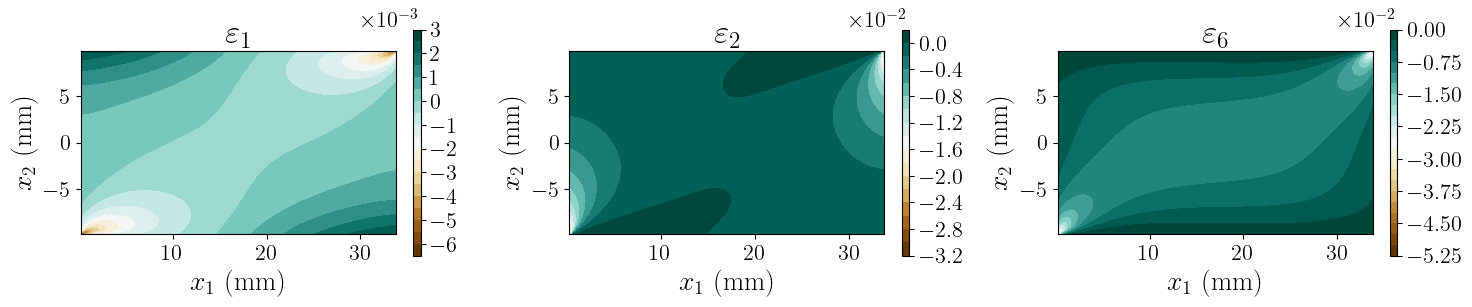

In [20]:
vfm.plot_strain_fields()


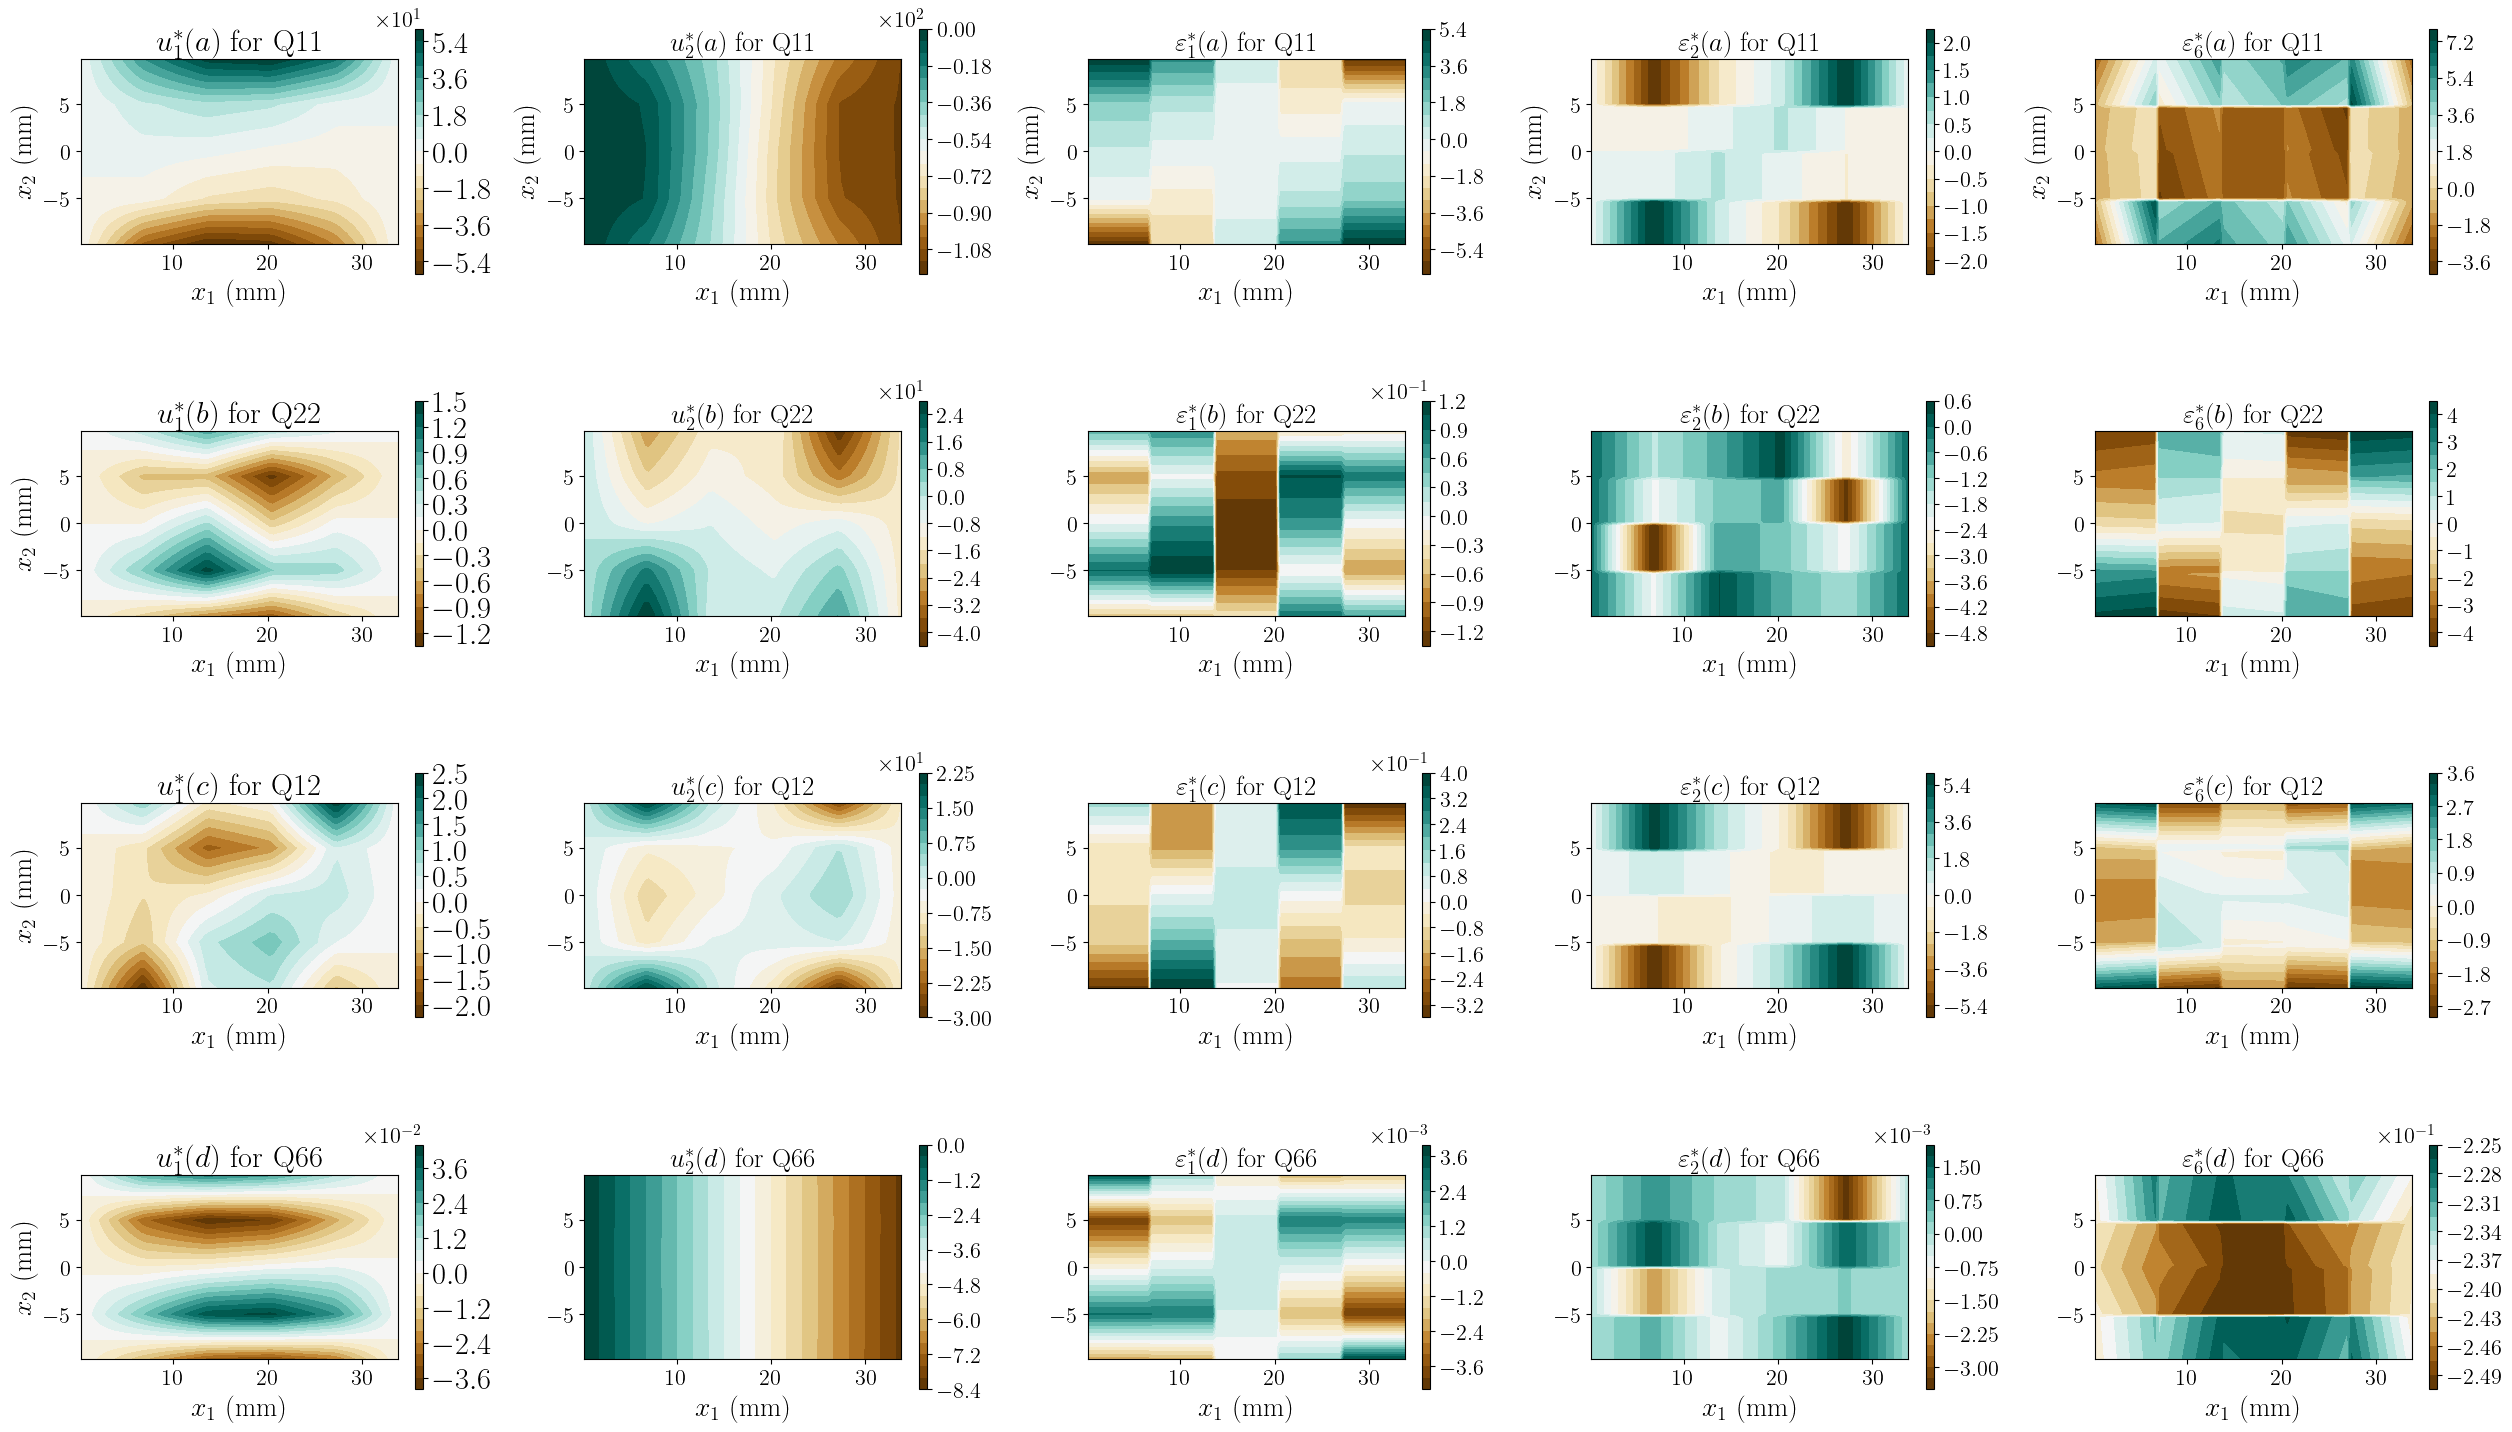

{'a': {'u1': array([[-1.28321256, -3.84963767, -6.41606278, ..., -5.24679887,
          -3.14807932, -1.04935977],
         [-1.18326755, -3.54980266, -5.91633776, ..., -4.9387634 ,
          -2.96325804, -0.98775268],
         [-1.08332255, -3.24996765, -5.41661274, ..., -4.63072793,
          -2.77843676, -0.92614559],
         ...,
         [ 0.92421834,  2.77265501,  4.62109168, ...,  5.40476377,
           3.24285826,  1.08095275],
         [ 0.98542139,  2.95626417,  4.92710694, ...,  5.90179253,
           3.54107552,  1.18035851],
         [ 1.04662444,  3.13987333,  5.23312221, ...,  6.39882129,
           3.83929277,  1.27976426]]),
  'u2': array([[  -0.51332524,   -1.53997572,   -2.56662621, ..., -112.1960072 ,
          -113.27639954, -114.35679188],
         [  -0.48634332,   -1.45902995,   -2.43171659, ..., -112.32874462,
          -113.356042  , -114.38333937],
         [  -0.4593614 ,   -1.37808419,   -2.29680698, ..., -112.46148204,
          -113.43568445, -114.409886

In [21]:
vfm.plot_virtual_fields()